In [1]:
from IPython.display import Image, display, Math

import matplotlib.pyplot as pl
from matplotlib.ticker import MaxNLocator
import numpy as np
import reddemcee

np.random.seed(1234)

# Autocorrelation Analysis
In this section we will use the 2D gaussian shells again:

The likelihood is given by:

$$ p(\vec{\theta}) = \sum_{i=1}^n \frac{1}{\sqrt{2\pi w^2}} \exp{\left( -\frac{(|\vec{\theta} - \vec{c_i}| - r)^2}{2w^2} \right)} $$

where $n$ are the number of dimensions, $r$ corresponds to the radius, $w$ the width and $\vec{c_i}$ to the constant vectors describing the centre of the peaks.

## Definitions
We define the constants and functions needed:

In [2]:
ndim_ = 2  # n dimensions
r_ = 2.  # radius
w_ = 0.1  # width
hard_limit = 6  # hard search boundary

limits_ = [-hard_limit,  hard_limit]
c1_ = np.zeros(ndim_)
c1_[0] = -3.5
c2_ = np.zeros(ndim_)
c2_[0] = 3.5
const_ = np.log(1. / np.sqrt(2. * np.pi * w_**2))

In [3]:
def logcirc(theta, c):
    # log-likelihood of a single shell
    d = np.sqrt(np.sum((theta - c)**2, axis=-1))  # |theta - c|
    return const_ - (d - r_)**2 / (2. * w_**2)


def loglike(theta):
    # log-likelihood of two shells
    return np.logaddexp(logcirc(theta, c1_), logcirc(theta, c2_))


def logprior(theta):
    # prior for our parameters
    lp = 0.
    for i in range(ndim_):
        if  theta[i] <= limits_[0] or limits_[1] <= theta[i]:
            return -np.inf
    return lp

def plot_betas_ratios(sampler, setup):
    bh = sampler.betas_history
    rh = sampler.ratios_history

    fig, axes = pl.subplots(2, 1, figsize=(9, 5), sharex=True)

    bh1 = bh.reshape((setup[2], setup[0]))
    rh1 = rh.reshape((setup[2], setup[0]-1))

    for i in range(setup[0]-2):
            bh_sel = bh1[:, i]
            b = 1/np.array(bh_sel)
            axes[0].plot(np.arange(setup[2])*setup[3], b)
            axes[0].set_xscale('log')
            axes[0].set_yscale('log')


    for i in np.arange(setup[0]-1):
        r = rh1[:, i]
        axes[1].plot(np.arange(setup[2])*setup[3], r, alpha=0.5)

    if True:
        axes[1].set_xlabel("N Step")
        axes[0].set_ylabel(r"$\beta^{-1}$")
        axes[1].set_ylabel(r"$a_{frac}$")

    pl.tight_layout()

## Setup
Here we write the sampler initial conditions:

In [4]:
setup = [10, 100, 500, 2]
ntemps, nwalkers, nsweeps, nsteps = setup
p0 = list(np.random.uniform(limits_[0], limits_[1], [ntemps, nwalkers, ndim_]))

In [5]:
##

In [6]:
sampler = reddemcee.PTSampler(nwalkers, ndim_, loglike, logprior,
                              ntemps=ntemps,
                              adaptative=True,
                              config_adaptation_halflife=500,
                              config_adaptation_rate=0.3,
                              config_adaptation_decay=0)
    
samples = sampler.run_mcmc(p0, nsweeps, nsteps, progress=True)

100%|████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.79it/s]


We take a look at the acceptance fractions:

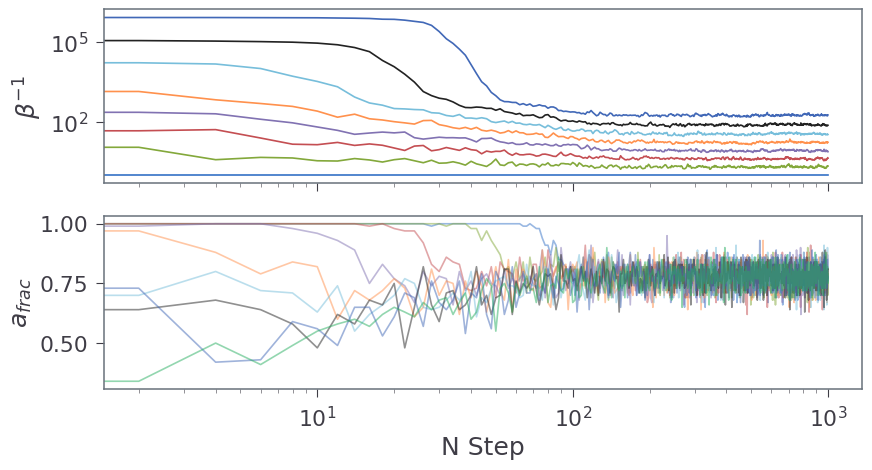

In [7]:
plot_betas_ratios(sampler, setup)

In [63]:
setup = [6, 10, 500, 2]
ntemps, nwalkers, nsweeps, nsteps = setup
p0 = list(np.random.uniform(limits_[0], limits_[1], [ntemps, nwalkers, ndim_]))

In [64]:
sampler = reddemcee.PTSampler(nwalkers, ndim_, loglike, logprior,
                              ntemps=ntemps,
                              adaptative=True,
                              config_adaptation_halflife=500,
                              config_adaptation_rate=0.3,
                              config_adaptation_decay=0)

In [65]:
burnin0 = 50  # length of this 'minichain'
burnin0_runs = 10


state = p0
old_tau = np.inf
ac = np.empty(burnin0_runs)
tol_warn = 0  # gets a message if chain is shorter than this
tol0 = 50  # times tau should be shorter than the chain

for i in range(burnin0_runs):
    print(f'Memory free initial position: {i+1}/{burnin0_runs}')
    state = sampler.run_mcmc(state, burnin0, nsteps, progress=True)

    tau0 = sampler.get_func('get_autocorr_time', kwargs={'quiet':True, 'tol':tol_warn})[0]
    ac[i] = np.mean(tau0)

    niter = sampler[0].iteration
    converged = np.all(tau0 * tol0 < niter)
    print(f'converge: {converged}')

    converged &= np.all(np.abs(old_tau - tau0) / tau0 < 0.1)

    print(f'ACi     : {ac[i]}')
    print(f'tau     : {tau0}')
    print(f'niter   : {niter}')
    print(f'converge: {converged}')

    if converged:
        print(f'CONVERGED! ')
        #print(f'AC     : {ac}')
        #for j in range(100):
        #  p2 = state

        #  for t in range(ntemps):
        #    for n in range(nwalkers):
        #      position_evaluated = p2[t][n]
        #      if my_prior(position_evaluated) == -np.inf:
        #        print(f'scramble init n = {j}')
        #        state = sampler.run_mcmc(p2, 1, nsteps, progress=True)
        #  else:
        #    continue

        break
      
    old_tau = tau0
      
sampler.reset()

auto_nsweeps = int((max(tau0) * tol0)//2)

sampler.adaptative = False
samples = sampler.run_mcmc(state, auto_nsweeps, nsteps,
                           progress=True)

total_sweeps = sampler[0].iteration//2
burnin_nsweeps = total_sweeps - auto_nsweeps

Memory free initial position: 1/10


100%|██████████████| 100/100 [00:00<00:00, 307.09it/s]


converge: False
ACi     : 5.429788128802899
tau     : [4.94077575 5.9188005 ]
niter   : 100
converge: False
Memory free initial position: 2/10


100%|██████████████| 100/100 [00:00<00:00, 333.92it/s]


converge: False
ACi     : 8.771007825410202
tau     : [9.20618693 8.33582872]
niter   : 200
converge: False
Memory free initial position: 3/10


100%|██████████████| 100/100 [00:00<00:00, 331.48it/s]


converge: False
ACi     : 13.913370771482167
tau     : [15.57166412 12.25507743]
niter   : 300
converge: False
Memory free initial position: 4/10


100%|██████████████| 100/100 [00:00<00:00, 332.05it/s]


converge: False
ACi     : 13.432899362261736
tau     : [13.61445518 13.25134354]
niter   : 400
converge: False
Memory free initial position: 5/10


100%|██████████████| 100/100 [00:00<00:00, 331.75it/s]


converge: False
ACi     : 14.59390909530704
tau     : [15.21358311 13.97423508]
niter   : 500
converge: False
Memory free initial position: 6/10


100%|██████████████| 100/100 [00:00<00:00, 320.80it/s]


converge: False
ACi     : 15.888889063249685
tau     : [16.94000963 14.8377685 ]
niter   : 600
converge: False
Memory free initial position: 7/10


100%|██████████████| 100/100 [00:00<00:00, 325.16it/s]


converge: False
ACi     : 17.966434164261326
tau     : [20.26406726 15.66880107]
niter   : 700
converge: False
Memory free initial position: 8/10


100%|██████████████| 100/100 [00:00<00:00, 327.89it/s]


converge: False
ACi     : 18.401555559810344
tau     : [21.49609351 15.30701761]
niter   : 800
converge: False
Memory free initial position: 9/10


100%|██████████████| 100/100 [00:00<00:00, 325.42it/s]


converge: False
ACi     : 18.71431659842692
tau     : [22.32965433 15.09897887]
niter   : 900
converge: False
Memory free initial position: 10/10


100%|██████████████| 100/100 [00:00<00:00, 336.89it/s]


converge: False
ACi     : 19.4321580066801
tau     : [22.09345367 16.77086234]
niter   : 1000
converge: False


100%|████████████| 1104/1104 [00:03<00:00, 340.21it/s]


In [66]:
#sampler.get_chains(flat=False).shape

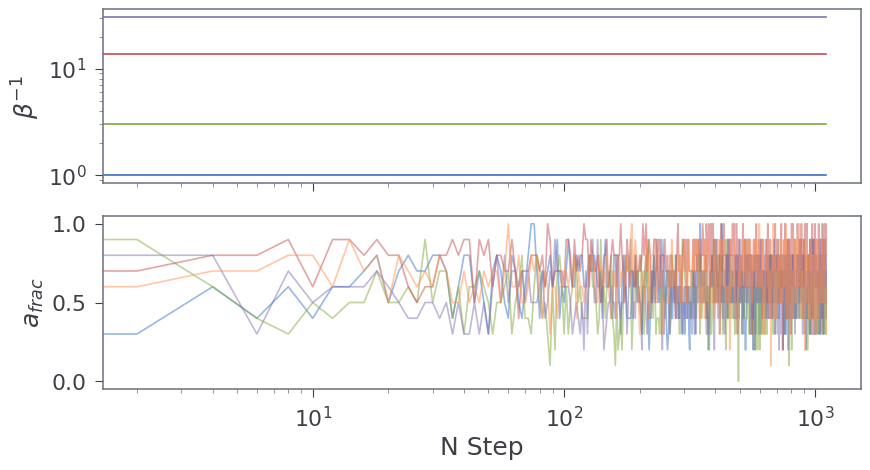

In [67]:
plot_betas_ratios(sampler, [ntemps, nwalkers, total_sweeps, nsteps])

In [68]:
print(f'ntemps, nwalkers = {ntemps}, {nwalkers}')
print(f'Af = {np.round(sampler.get_attr("acceptance_fraction").mean(axis=1), 2)}')
print(f'Af mean = {np.round(sampler.get_attr("acceptance_fraction").mean(), 2)}')
print(f'Sr = {np.round(sampler.ratios_history.reshape((total_sweeps, setup[0]-1)).mean(axis=0), 2)}')
print(f'Sr mean = {np.round(sampler.ratios_history.reshape((total_sweeps, setup[0]-1)).mean(), 2)}')
print(f'Z = {sampler.thermodynamic_integration()[0]:.2f} +-{sampler.thermodynamic_integration()[1]:.2f}')

ntemps, nwalkers = 6, 10
Af = [0.19 0.25 0.39 0.47 0.63 0.63]
Af mean = 0.43
Sr = [0.6  0.53 0.76 0.56 0.66]
Sr mean = 0.62
Z = -2.16 +-0.75


In [62]:
print(f'ntemps, nwalkers = {ntemps}, {nwalkers}')
print(f'Af = {np.round(sampler.get_attr("acceptance_fraction").mean(axis=1), 2)}')
print(f'Af mean = {np.round(sampler.get_attr("acceptance_fraction").mean(), 2)}')
print(f'Sr = {np.round(sampler.ratios_history.reshape((total_sweeps, setup[0]-1)).mean(axis=0), 2)}')
print(f'Sr mean = {np.round(sampler.ratios_history.reshape((total_sweeps, setup[0]-1)).mean(), 2)}')
print(f'Z = {sampler.thermodynamic_integration()[0]:.2f} +-{sampler.thermodynamic_integration()[1]:.2f}')

ntemps, nwalkers = 10, 10
Af = [0.18 0.22 0.27 0.35 0.44 0.51 0.56 0.64 0.66 0.64]
Af mean = 0.45
Sr = [0.83 0.85 0.68 0.85 0.81 0.75 0.7  0.79 0.79]
Sr mean = 0.78
Z = -1.84 +-0.29


In [56]:
print(f'ntemps, nwalkers = {ntemps}, {nwalkers}')
print(f'Af = {np.round(sampler.get_attr("acceptance_fraction").mean(axis=1), 2)}')
print(f'Af mean = {np.round(sampler.get_attr("acceptance_fraction").mean(), 2)}')
print(f'Sr = {np.round(sampler.ratios_history.reshape((total_sweeps, setup[0]-1)).mean(axis=0), 2)}')
print(f'Sr mean = {np.round(sampler.ratios_history.reshape((total_sweeps, setup[0]-1)).mean(), 2)}')
print(f'Z = {sampler.thermodynamic_integration()[0]:.2f} +-{sampler.thermodynamic_integration()[1]:.2f}')

ntemps, nwalkers = 10, 32
Af = [0.18 0.22 0.26 0.32 0.41 0.49 0.57 0.62 0.65 0.62]
Af mean = 0.43
Sr = [0.81 0.76 0.79 0.76 0.79 0.71 0.77 0.81 0.8 ]
Sr mean = 0.78
Z = -1.84 +-0.26


In [50]:

print(f'ntemps, nwalkers = {ntemps}, {nwalkers}')
print(f'Af = {np.round(sampler.get_attr("acceptance_fraction").mean(axis=1), 2)}')
print(f'Af mean = {np.round(sampler.get_attr("acceptance_fraction").mean(), 2)}')
print(f'Sr = {np.round(sampler.ratios_history.reshape((total_sweeps, setup[0]-1)).mean(axis=0), 2)}')
print(f'Sr mean = {np.round(sampler.ratios_history.reshape((total_sweeps, setup[0]-1)).mean(), 2)}')
print(f'Z = {sampler.thermodynamic_integration()[0]:.2f} +-{sampler.thermodynamic_integration()[1]:.2f}')

ntemps, nwalkers = 10, 100
Af = [0.18 0.22 0.28 0.33 0.4  0.49 0.55 0.63 0.65 0.62]
Af mean = 0.44
Sr = [0.79 0.81 0.71 0.82 0.78 0.76 0.8  0.77 0.78]
Sr mean = 0.78
Z = -1.86 +-0.26


(np.float64(-1.8564479948709314),
 np.float64(0.26091882740199107),
 np.float64(0.26084299463433536),
 np.float64(0.00629020214477361))

In [34]:
def display_samples(sampler, temp=0):
    nd = sampler.ndim
    fig, axes = pl.subplots(1, nd, figsize=(8, 2*nd))
    
    samples = sampler.get_chains(flat=True)
    
    for i in range(len(axes)):
        axes[i].hist(samples[temp][:, i], 100, histtype="step", lw=1)
        axes[i].set_xlabel(fr"$\theta_{i}$")
        axes[i].set_ylabel(fr"$p(\theta_{i})$")
    pl.gca().set_yticks([])
    fig.suptitle('Samples')
  

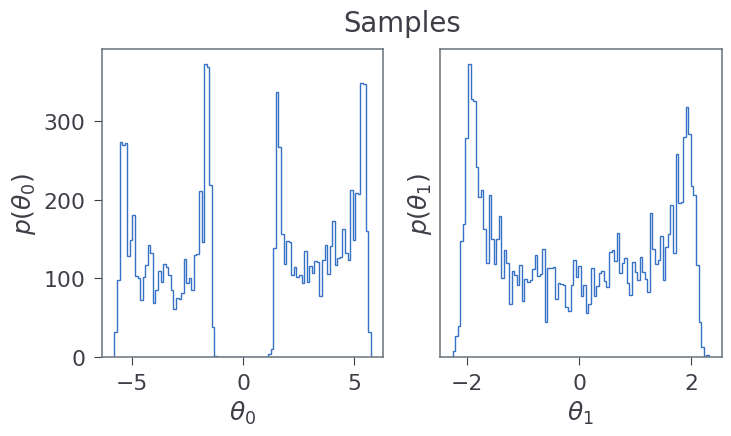

In [69]:
display_samples(sampler, temp=0)